Basic scikits-leaarn toolchain msetup

In [31]:
from multiprocessing import cpu_count

import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier as Classifier
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("../small.mplstyle")

/home/zah/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [32]:
import itertools
d = {1: (1,2,3), 10: (10,20,30)}
def dict_product(d):
    return ({k:v for k,v in zip(d.keys(), vals)} for vals in itertools.product(*d.values()))
list(dict_product(d))

[{1: 1, 10: 10},
 {1: 1, 10: 20},
 {1: 1, 10: 30},
 {1: 2, 10: 10},
 {1: 2, 10: 20},
 {1: 2, 10: 30},
 {1: 3, 10: 10},
 {1: 3, 10: 20},
 {1: 3, 10: 30}]

In [113]:
RANDOM_SEED = 0xdeadbeef

In [114]:
signal = pd.DataFrame.from_csv('../ML_Events/NoCuts/signal_nocuts.txt', index_col= 0, sep='\t')
background = pd.DataFrame.from_csv('../ML_Events/NoCuts/background_nocuts.txt', index_col= 0, sep='\t')
signal.columns = background.columns = [s.strip() for s in signal.columns]

#Drop empy columns
emptycols = [c for c in signal.columns if c.startswith("Empty")]
signal.drop(emptycols, axis=1, inplace=True)
background.drop(emptycols, axis=1, inplace=True)

#Balance signal and background weights. Otherwise saying that everything is a signal is a cheap
#local minimum.
background.Weight *= signal.Weight.sum()/ background.Weight.sum()


data = pd.concat([signal, background])
features, weights = data.iloc[:, :-1], data.iloc[:,-1]
weights = np.abs(weights).as_matrix()
labels = np.r_[np.ones(len(signal)), np.zeros(len(background))]

#We split between testing and training by further starifying on weights, by ignoring the smaller ones for each
#category (for the purposes of splitting, we assign them to a third category '2' that tunrns out to be split evenly as well).
weighted_cats = labels.copy()
label_mask = labels.astype(bool)
small_signal = (weights < weights[label_mask].mean()) & label_mask
weighted_cats[small_signal] = 2

small_background = (weights < weights[~label_mask].mean()) & ~label_mask
weighted_cats[small_background] = 2


X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features, labels, weights,
                                                                     random_state = RANDOM_SEED, 
                                                                     test_size=0.5, stratify=weighted_cats)



#X_train, y_train, w_train = features, labels, weights

cols = features.columns

In [115]:
cols

Index(['W pT', '| Delta eta j1,j2 |', 'Delta R j1,j2', 'm j1, j2', 'N of jets',
       'j1 pT', 'j2 pT', 'Centrality', '| Delta Phi l1, l2 |', 'm l1, l2',
       '| Delta eta l1,l2 |', 'mET (scalar)', 'mET phi', 'dijet min distance',
       'Zeppenfeld Var', 'Cos |tot phi|', 'Cos | deltaphi(j1+j2,l1+l2) |'],
      dtype='object')

In [116]:
def mask_cuts(data):
    return (data['m j1, j2'] > 500) & (data['| Delta eta j1,j2 |'] > 2.4)

def cuts(data):
    return data[mask_cuts(data)]

In [117]:
signal_cut = cuts(signal)
background_cut = cuts(background)

In [118]:
len(signal_cut)

1195

In [119]:
len(background)

1320

In [120]:
len(signal)

5145

In [121]:
len(background_cut)

125

(array([  2.00000000e+00,   2.00000000e+00,   1.10000000e+01,
          2.80000000e+01,   7.90000000e+01,   2.22000000e+02,
          7.30000000e+02,   1.95700000e+03,   2.52900000e+03,
          9.05000000e+02]),
 array([-17.90047474, -15.9033677 , -13.90626067, -11.90915363,
         -9.91204659,  -7.91493956,  -5.91783252,  -3.92072549,
         -1.92361845,   0.07348859,   2.07059562]),
 <a list of 10 Patch objects>)

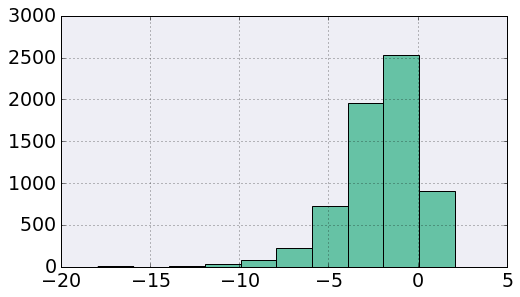

In [122]:
plt.hist(np.log10(weights))

In [123]:
len(data)

6465

In [124]:
sum(w_test)

2670.5188894054786

In [125]:
sum(w_train)

2945.0843923774773

In [126]:
sum(y_train*w_train)

1482.6966036975575

In [127]:
sum(y_test*w_test)

1327.9913744367827

In [128]:
len(cols)

17

In [129]:
clf = Classifier(n_estimators=3000, 
                 learning_rate=2,
                 #max_depth=10,
                 #criterion = "gini",
                 #max_features = 3,
                 min_weight_fraction_leaf=0.20,
                 #bootstrap = False,
                 #oob_score=True,
                 #class_weight="balanced_subsample",
                 #n_jobs=cpu_count(),
                 #subsample=0.3,
                 random_state=RANDOM_SEED)

In [130]:
clf.min_weight_fraction_leaf = 100

In [133]:
w_fractions = np.r_[np.logspace(-5,-2, 8) , np.linspace(0.1, 0.5, 20)]
params = {'min_weight_fraction_leaf': w_fractions}

In [134]:
def grid_fit(clf, params, X, Y, score, sample_weight=None):
    for spec in dict_product(params):
        for key in spec:
            setattr(clf, key, spec[key])
        clf.fit(X,Y,sample_weight=sample_weight)
        yield (spec, score(clf))

In [135]:
from sklearn.metrics import roc_auc_score, roc_curve

def score(clf):
    return roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], sample_weight=w_test)

In [136]:
it = iter(grid_fit(clf, params, X_train, y_train, score=score, sample_weight=w_train))

In [137]:
list(it)

[({'min_weight_fraction_leaf': 1.0000000000000001e-05}, 0.653682094590607),
 ({'min_weight_fraction_leaf': 2.6826957952797274e-05}, 0.7037582053680641),
 ({'min_weight_fraction_leaf': 7.1968567300115141e-05}, 0.68294520359076316),
 ({'min_weight_fraction_leaf': 0.00019306977288832496}, 0.67978297356963668),
 ({'min_weight_fraction_leaf': 0.0005179474679231213}, 0.66058267356108147),
 ({'min_weight_fraction_leaf': 0.0013894954943731374}, 0.69121858618484988),
 ({'min_weight_fraction_leaf': 0.0037275937203149379}, 0.72425292638923378),
 ({'min_weight_fraction_leaf': 0.01}, 0.77186385700538451),
 ({'min_weight_fraction_leaf': 0.10000000000000001}, 0.62218210782341121),
 ({'min_weight_fraction_leaf': 0.12105263157894737}, 0.69779771863842743),
 ({'min_weight_fraction_leaf': 0.14210526315789473}, 0.52833526844530943),
 ({'min_weight_fraction_leaf': 0.16315789473684211}, 0.5),
 ({'min_weight_fraction_leaf': 0.18421052631578949}, 0.76277856904631725),
 ({'min_weight_fraction_leaf': 0.20526315

In [109]:
from concurrent.futures import ProcessPoolExecutor
pool = ProcessPoolExecutor()
result = pool.map(it)

In [111]:
pool.map??

In [138]:
max(_, key=lambda x: x[1])

({'min_weight_fraction_leaf': 0.01}, 0.77186385700538451)

In [139]:
clf.min_weight_fraction_leaf = 0.01#_[0]['min_weight_fraction_leaf']

In [140]:
clf.fit(X_train,y_train, sample_weight=w_train)

GradientBoostingClassifier(init=None, learning_rate=2, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.01, n_estimators=3000,
              presort='auto', random_state=3735928559, subsample=1.0,
              verbose=0, warm_start=False)

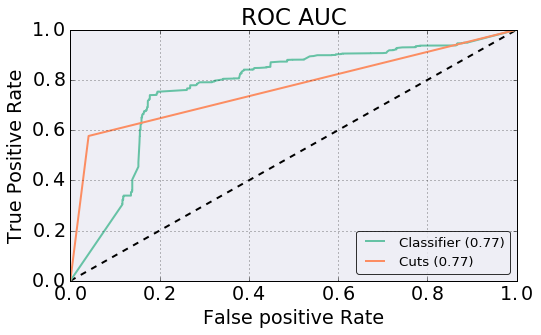

In [141]:



predicted_test = clf.predict_proba(X_test)[:,1]
predicted_train = clf.predict_proba(X_train)[:,1]

predicted_test_cuts  = mask_cuts(X_test)

fpr, tpr, thresholds = roc_curve(y_test, predicted_test, sample_weight=w_test)
fpr_cuts, tpr_cuts, thresholds_cuts = roc_curve(y_test, predicted_test_cuts, sample_weight=w_test)
#fpr, tpr, thresholds = roc_curve(y_train, predicted_train, sample_weight=w_train)

clf_score = roc_auc_score(y_test, predicted_test, sample_weight=w_test)
cut_score = roc_auc_score(y_test, predicted_test_cuts, sample_weight=w_test)

plt.plot(fpr, fpr, 'k--')

plt.plot(fpr, tpr, label="Classifier (%.2f)" % clf_score)

plt.plot(fpr_cuts, tpr_cuts, label="Cuts (%.2f)" % cut_score)

plt.title("ROC AUC")
plt.xlabel("False positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

In [142]:
clf.score(X_test, y_test, sample_weight=w_test)

0.73906159379803915

In [143]:
clf.score(X_train, y_train, sample_weight=w_train)

0.87381706638048662

In [144]:
e = clf.estimators_[0][0]

In [145]:
e.tree_.impurity

array([ 0.24998811,  0.22538597,  0.24752772,  0.17665229,  0.22637797,
        0.13155544,  0.1968907 ,  0.09635133,  0.08191872,  0.23602634,
        0.16732772,  0.17116064,  0.03053046,  0.15470898,  0.02148921])

In [146]:
importances = clf.feature_importances_

In [147]:
import matplotlib.pyplot as plt

In [148]:
importances = pd.Series(importances, index=features.columns)

In [149]:
sv = importances.sort_values()
c,d = sv.index[-2:]

In [150]:
best_features = sv.index[-4:]

In [151]:
sv

N of jets                        0.000000
Cos |tot phi|                    0.000000
j2 pT                            0.000024
mET (scalar)                     0.000052
mET phi                          0.000097
Cos | deltaphi(j1+j2,l1+l2) |    0.000136
dijet min distance               0.000143
m l1, l2                         0.000194
| Delta Phi l1, l2 |             0.000235
Zeppenfeld Var                   0.000354
W pT                             0.000450
| Delta eta j1,j2 |              0.001269
m j1, j2                         0.056145
Delta R j1,j2                    0.140426
j1 pT                            0.193564
Centrality                       0.229997
| Delta eta l1,l2 |              0.376915
dtype: float64

In [152]:
mask_cuts??

In [153]:
best_features

Index(['Delta R j1,j2', 'j1 pT', 'Centrality', '| Delta eta l1,l2 |'], dtype='object')

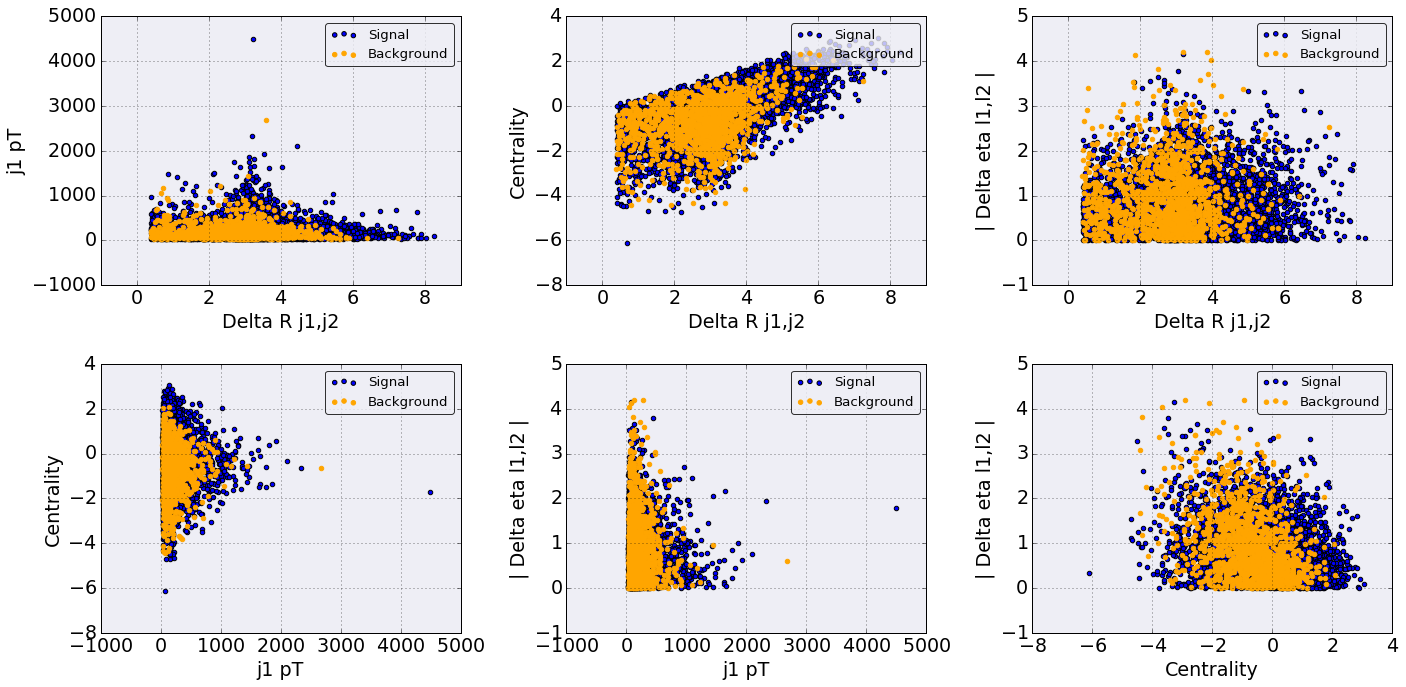

In [154]:
import itertools
pairs = (itertools.combinations(best_features,2))
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axiter = (ax  for l in axes for ax in l)
for (c,d), ax in zip(pairs, axiter):
    ax.scatter(c,d, data=signal, label="Signal")
    ax.scatter(c,d, data=background, color='orange', label="Background")
    ax.set_xlabel(c)
    ax.set_ylabel(d)
    ax.legend(loc='best')
plt.tight_layout()
plt.savefig("features.pdf")
    

In [155]:
proba_test = clf.predict_proba(X_test)

In [156]:
import statsmodels.api as sm

In [157]:
cols

Index(['W pT', '| Delta eta j1,j2 |', 'Delta R j1,j2', 'm j1, j2', 'N of jets',
       'j1 pT', 'j2 pT', 'Centrality', '| Delta Phi l1, l2 |', 'm l1, l2',
       '| Delta eta l1,l2 |', 'mET (scalar)', 'mET phi', 'dijet min distance',
       'Zeppenfeld Var', 'Cos |tot phi|', 'Cos | deltaphi(j1+j2,l1+l2) |'],
      dtype='object')

(0, 2000)

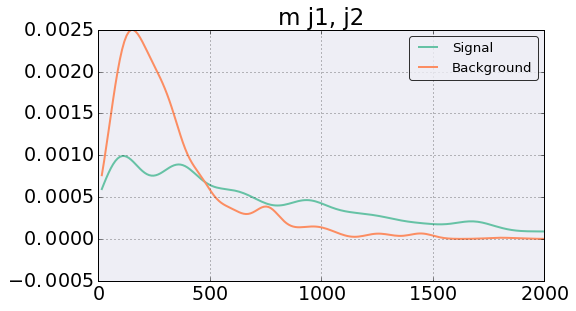

In [158]:
feature = 'm j1, j2'
dens_sig = sm.nonparametric.KDEUnivariate(signal[feature].as_matrix())
dens_sig.fit(weights=signal.Weight.as_matrix(), fft=False)

dens_bg= sm.nonparametric.KDEUnivariate(background[feature].as_matrix())
dens_bg.fit(weights=background.Weight.as_matrix(), fft=False)
plt.figure()
plt.title(feature)

x = np.linspace(data[feature].min(), data[feature].max(), 1000)
plt.plot(x, dens_sig.evaluate(x), label="Signal")
plt.plot(x, dens_bg.evaluate(x), label="Background")
plt.legend()
plt.xlim(0,2000)

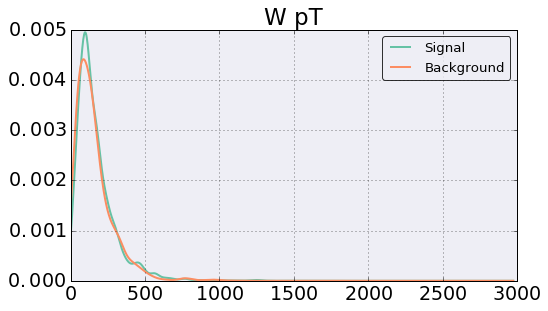

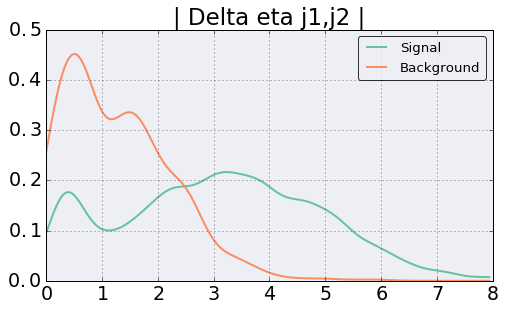

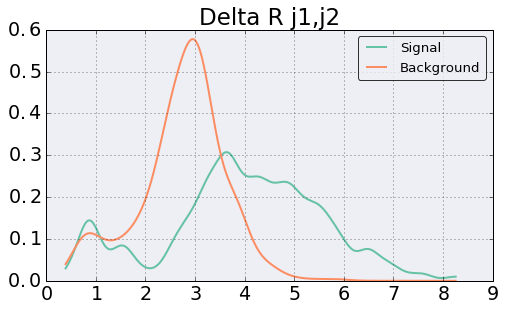

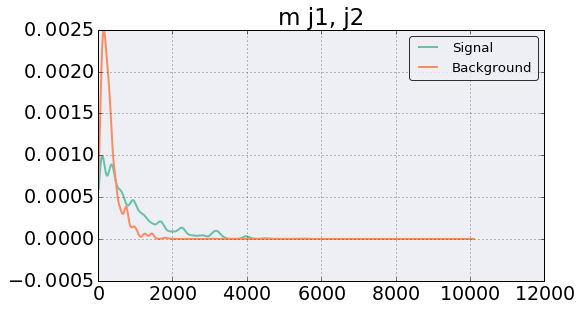

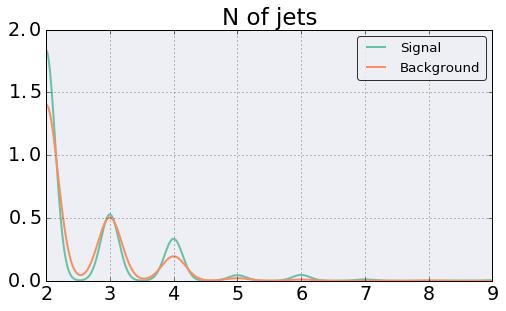

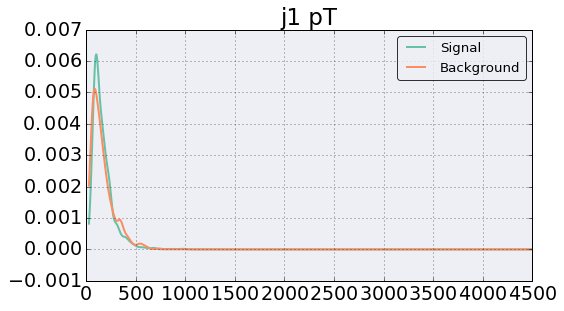

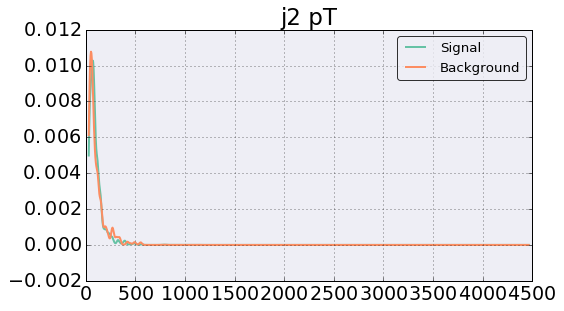

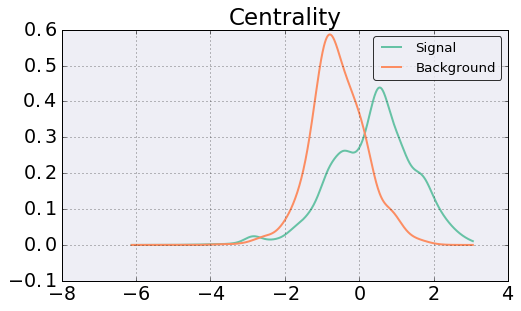

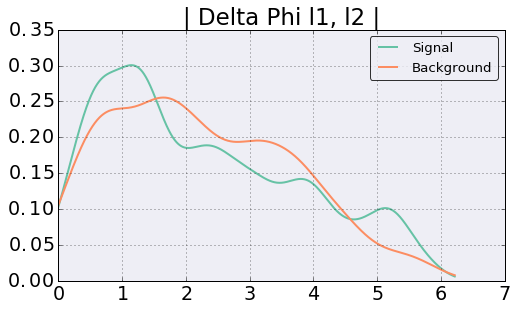

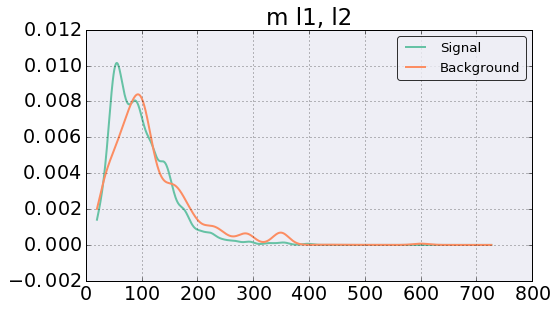

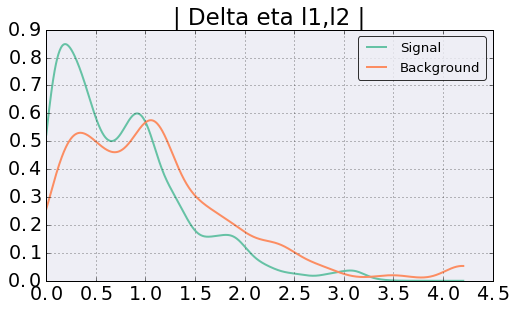

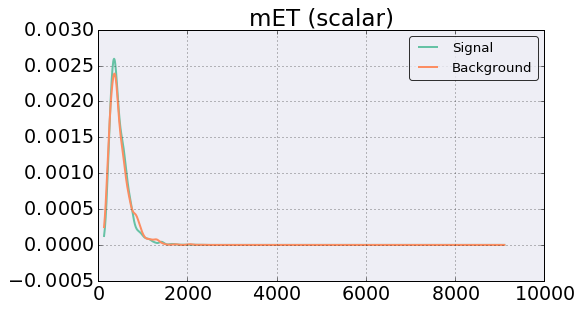

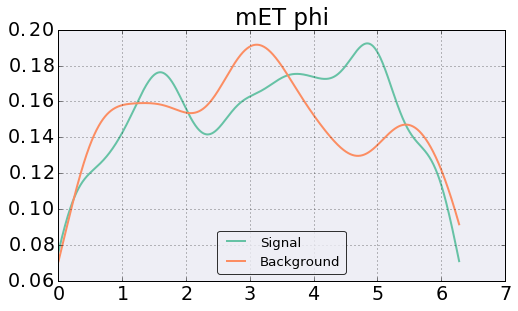

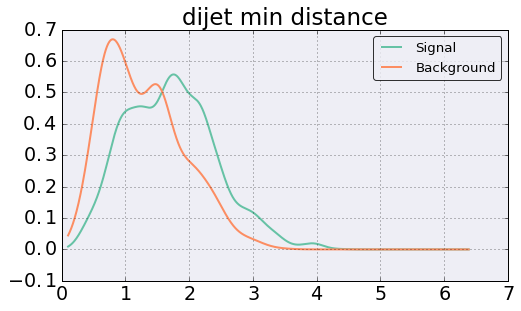

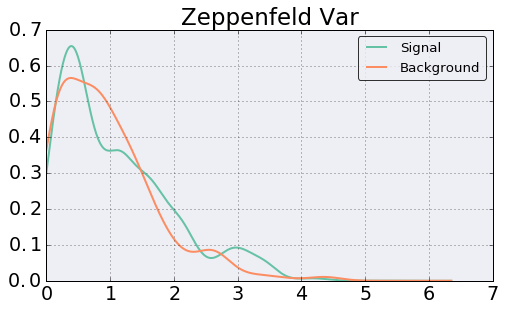

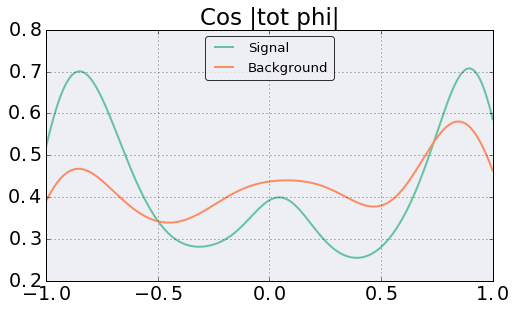

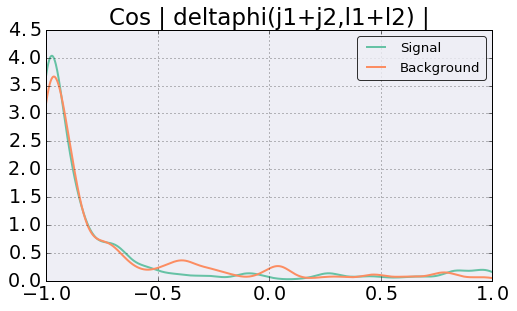

In [159]:
for feature in cols:
    
    dens_sig = sm.nonparametric.KDEUnivariate(signal[feature].as_matrix())
    dens_sig.fit(weights=signal.Weight.as_matrix(), fft=False)

    dens_bg= sm.nonparametric.KDEUnivariate(background[feature].as_matrix())
    dens_bg.fit(weights=background.Weight.as_matrix(), fft=False)
    plt.figure()
    plt.title(feature)
    
    x = np.linspace(data[feature].min(), data[feature].max(), 1000)
    plt.plot(x, dens_sig.evaluate(x), label="Signal")
    plt.plot(x, dens_bg.evaluate(x), label="Background")
    plt.legend()

In [160]:
probs = np.linspace(0,1,30)

In [161]:
clf.estimators_[0]

array([ DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.01,
           presort='auto',
           random_state=<mtrand.RandomState object at 0x7f2a30b280f0>,
           splitter='best')], dtype=object)

In [162]:
from sklearn.tree import export_graphviz

In [163]:
clf.predict_proba(signal[cols])[:,1];

In [164]:
sp = clf.predict_proba(signal[cols])[:,1]
bp = clf.predict_proba(background[cols])[:,1]

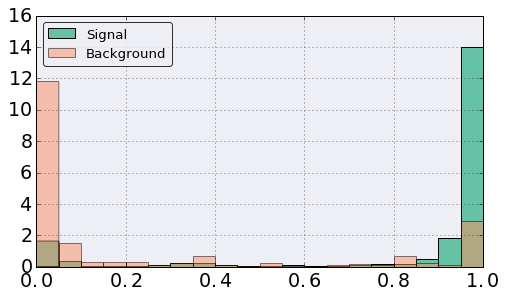

In [170]:
plt.hist(sp, weights=signal.Weight.abs(), normed=True, bins=20, label="Signal")
plt.hist(bp, weights=background.Weight.abs(), normed=True, bins=20, alpha=0.5, label="Background")
plt.legend()

In [166]:
len(signal_cut) / len(background_cut)

9.56

In [167]:
len(signal_cut) / np.sqrt(len(background_cut))

106.88404932448994

In [168]:
len(signal) / len(background)

3.897727272727273

In [169]:
len(signal) / np.sqrt(len(background))

141.61146428937815